### Import Libraries

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)
from imblearn.over_sampling import SMOTE

###  Data Loading

In [50]:
train_df = pd.read_csv(r"C:\Users\sg200\Downloads\train_u6lujuX_CVtuZ9i.csv")
test_df = pd.read_csv(r"C:\Users\sg200\Downloads\test_Y3wMUE5_7gLdaTN.csv")

print("Dataset shapes:")
print(f"Training: {train_df.shape}")
print(f"Test: {test_df.shape}")
print("\nTraining data info:")
print(train_df.info())

Dataset shapes:
Training: (614, 13)
Test: (367, 12)

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None


### Robust Data Preprocessor Class

In [52]:
class RobustLoanDataPreprocessor:
    def __init__(self):
        self.numeric_imputer = None
        self.categorical_imputer = None
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.feature_columns = None
        # Explicit column lists for consistency
        self.numeric_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
        self.categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
        self.fitted = False

    def preprocess_train(self, df):
        df_processed = df.copy()

        self.train_loan_ids = df_processed['Loan_ID'] if 'Loan_ID' in df_processed.columns else None

        df_processed['Dependents'] = df_processed['Dependents'].replace('3+', '3')

        for col in self.numeric_cols:
            if col in df_processed.columns:
                df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')

        self.numeric_imputer = SimpleImputer(strategy='median')
        self.categorical_imputer = SimpleImputer(strategy='most_frequent')

        df_processed[self.numeric_cols] = self.numeric_imputer.fit_transform(df_processed[self.numeric_cols])
        df_processed[self.categorical_cols] = self.categorical_imputer.fit_transform(df_processed[self.categorical_cols])

        df_processed = self._create_basic_features(df_processed)

        for col in self.categorical_cols:
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col].astype(str))
            self.label_encoders[col] = le

        self.feature_columns = [col for col in df_processed.columns if col not in ['Loan_ID', 'Loan_Status']]
        self.fitted = True

        if 'Loan_ID' in df_processed.columns:
            df_processed = df_processed.drop('Loan_ID', axis=1)

        return df_processed

    def preprocess_test(self, df):
        if not self.fitted:
            raise ValueError("Must call preprocess_train first!")

        df_processed = df.copy()

        self.test_loan_ids = df_processed['Loan_ID'] if 'Loan_ID' in df_processed.columns else None

        df_processed['Dependents'] = df_processed['Dependents'].replace('3+', '3')

        for col in self.numeric_cols:
            if col not in df_processed.columns:
                df_processed[col] = np.nan
            df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')

        for col in self.categorical_cols:
            if col not in df_processed.columns:
                df_processed[col] = np.nan

        df_processed[self.numeric_cols] = self.numeric_imputer.transform(df_processed[self.numeric_cols])
        df_processed[self.categorical_cols] = self.categorical_imputer.transform(df_processed[self.categorical_cols])

        df_processed = self._create_basic_features(df_processed)

        for col in self.categorical_cols:
            le = self.label_encoders[col]
            known_classes = set(le.classes_)
            df_processed[col] = df_processed[col].astype(str)
            df_processed[col] = df_processed[col].where(df_processed[col].isin(known_classes), le.classes_[0])
            df_processed[col] = le.transform(df_processed[col])

        if 'Loan_ID' in df_processed.columns:
            df_processed = df_processed.drop('Loan_ID', axis=1)

        for col in self.feature_columns:
            if col not in df_processed.columns:
                df_processed[col] = 0
        extra_cols = set(df_processed.columns) - set(self.feature_columns)
        if extra_cols:
            df_processed = df_processed.drop(list(extra_cols), axis=1)
        df_processed = df_processed[self.feature_columns]

        return df_processed

    def _create_basic_features(self, df):
        df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
        df['HasCoapplicant'] = (df['CoapplicantIncome'] > 0).astype(int)
        return df

    def add_advanced_features(self, df, is_train=True):
        df_advanced = df.copy()
        df_advanced['IncomeToLoanRatio'] = df_advanced['TotalIncome'] / (df_advanced['LoanAmount'] + 1)
        df_advanced['LoanToIncomeRatio'] = df_advanced['LoanAmount'] / (df_advanced['TotalIncome'] + 1)
        df_advanced['EMI'] = df_advanced['LoanAmount'] * 0.0085 * (1 + 0.0085) ** df_advanced['Loan_Amount_Term'] / ((1 + 0.0085) ** df_advanced['Loan_Amount_Term'] - 1 + 1e-8)
        df_advanced['EMIToIncomeRatio'] = df_advanced['EMI'] / (df_advanced['TotalIncome'] + 1)
        df_advanced['IncomeStability'] = df_advanced['ApplicantIncome'] / (df_advanced['CoapplicantIncome'] + 1)
        df_advanced['LogApplicantIncome'] = np.log1p(df_advanced['ApplicantIncome'])
        df_advanced['LogLoanAmount'] = np.log1p(df_advanced['LoanAmount'])
        df_advanced['LogTotalIncome'] = np.log1p(df_advanced['TotalIncome'])

        numerical_to_scale = [
            'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term',
            'TotalIncome', 'IncomeToLoanRatio', 'LoanToIncomeRatio', 'EMI',
            'EMIToIncomeRatio', 'IncomeStability', 'LogApplicantIncome',
            'LogLoanAmount', 'LogTotalIncome'
        ]
        available_numerical = [col for col in numerical_to_scale if col in df_advanced.columns]
        if available_numerical:
            if is_train:
                df_advanced[available_numerical] = self.scaler.fit_transform(df_advanced[available_numerical])
            else:
                df_advanced[available_numerical] = self.scaler.transform(df_advanced[available_numerical])
        return df_advanced

### Enhanced Exploratory Data Analysis 

In [60]:
def quick_eda(df, target_col='Loan_Status'):
    if target_col not in df.columns:
        print(f"Target column '{target_col}' not found!")
        return

    print(f"\n📊 EDA for {target_col}")
    print("=" * 50)

    target_counts = df[target_col].value_counts()
    print(f"Target distribution:\n{target_counts}")
    print(f"Target proportions:\n{target_counts / len(df)}")

    print(f"\nDataset shape: {df.shape}")
    print(f"Missing values: {df.isnull().sum().sum()}")

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"\nNumeric features ({len(numeric_cols)}): {list(numeric_cols)}")

    categorical_cols = df.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        print(f"Categorical features ({len(categorical_cols)}): {list(categorical_cols)}")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Target Distribution')

    if df[target_col].dtype in [np.int64, np.float64]:
        plt.subplot(1, 3, 2)
        numeric_df = df.select_dtypes(include=[np.number])
        if len(numeric_df.columns) > 1:
            correlations = numeric_df.corr()[target_col].abs().sort_values(ascending=False)
            correlations = correlations[correlations.index != target_col]
            if len(correlations) > 0:
                correlations.head(10).plot(kind='barh')
                plt.title('Top Feature Correlations with Target')

    plt.subplot(1, 3, 3)
    if 'Credit_History' in df.columns:
        credit_approval = df.groupby('Credit_History')[target_col].mean()
        plt.bar(['Bad Credit', 'Good Credit'], credit_approval.values)
        plt.title('Approval Rate by Credit History')
        plt.ylabel('Approval Rate')

    plt.tight_layout()
    plt.show()

### Robust Model Predictor Class (Training, Evaluation and Ensemble)

In [65]:
class RobustLoanPredictor:
    def __init__(self):
        self.models = {
            'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
            'RandomForest': RandomForestClassifier(random_state=42, n_estimators=100),
            'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
            'GradientBoosting': GradientBoostingClassifier(random_state=42, n_estimators=100)
        }
        self.best_models = {}

    def evaluate_model(self, model, X_test, y_test, model_name):
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred_proba)

        print(f"\n{model_name} Performance:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"AUC Score: {auc_score:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Rejected', 'Approved']))

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Rejected', 'Approved'],
                    yticklabels=['Rejected', 'Approved'])
        plt.title(f'{model_name} - Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        plt.subplot(1, 2, 2)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})', linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return accuracy, auc_score

    def train_models(self, X_train, y_train, X_val, y_val):
        results = {}

        print("🔄 Applying SMOTE to handle class imbalance...")
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        print(f"Before SMOTE: {np.bincount(y_train)}")
        print(f"After SMOTE: {np.bincount(y_train_resampled)}")

        for name, model in self.models.items():
            print(f"\n{'=' * 50}")
            print(f"Training {name}")
            print(f"{'=' * 50}")
            try:
                model.fit(X_train_resampled, y_train_resampled)
                self.best_models[name] = model
                accuracy, auc_score = self.evaluate_model(model, X_val, y_val, name)

                results[name] = {
                    'accuracy': accuracy,
                    'auc_score': auc_score,
                    'model': model
                }

            except Exception as e:
                print(f"Error training {name}: {e}")
                continue

        return results

    def create_ensemble(self, results, X_val, y_val):
        top_models = sorted(results.items(), key=lambda x: x[1]['auc_score'], reverse=True)[:3]

        print("\nTop models for ensemble:")
        for name, metrics in top_models:
            print(f"{name}: AUC = {metrics['auc_score']:.4f}")

        class VotingEnsemble:
            def __init__(self, models):
                self.models = models

            def predict_proba(self, X):
                probas = [model.predict_proba(X) for model in self.models]
                return np.mean(probas, axis=0)

            def predict(self, X):
                probas = self.predict_proba(X)
                return (probas[:, 1] > 0.5).astype(int)

        ensemble_models = [metrics['model'] for name, metrics in top_models]
        ensemble = VotingEnsemble(ensemble_models)

        accuracy, auc_score = self.evaluate_model(ensemble, X_val, y_val, "Voting Ensemble")

        results['Ensemble'] = {
            'accuracy': accuracy,
            'auc_score': auc_score,
            'model': ensemble
        }

        return results


### Final Prediction and Submission

In [69]:
def create_submission_robust(model, test_processed, test_original, model_name, feature_columns):
    test_final = test_processed.copy()

    print(f"\n🔧 Preparing submission with {len(feature_columns)} features...")

    missing_cols = set(feature_columns) - set(test_final.columns)
    if missing_cols:
        print(f"Adding {len(missing_cols)} missing columns: {list(missing_cols)}")
        for col in missing_cols:
            test_final[col] = 0

    extra_cols = set(test_final.columns) - set(feature_columns)
    if extra_cols:
        print(f"Removing {len(extra_cols)} extra columns: {list(extra_cols)}")
        test_final = test_final[feature_columns]
    else:
        test_final = test_final[feature_columns]

    print(f"✅ Final test shape: {test_final.shape}")
    print(f"✅ Column match: {all(test_final.columns == feature_columns)}")

    test_predictions = model.predict(test_final)
    test_probabilities = model.predict_proba(test_final)[:, 1]

    submission = pd.DataFrame({
        'Loan_ID': test_original['Loan_ID'],
        'Loan_Status': ['Y' if pred == 1 else 'N' for pred in test_predictions],
        'Probability_Approval': test_probabilities
    })

    submission_file = f'loan_prediction_submission_{model_name}.csv'
    submission[['Loan_ID', 'Loan_Status']].to_csv(submission_file, index=False)

    print(f"\n✅ Submission file '{submission_file}' created successfully!")
    print(f"📊 Predictions distribution:")
    print(submission['Loan_Status'].value_counts())
    print(f"📈 Approval rate: {(submission['Loan_Status'] == 'Y').mean():.1%}")

    print(f"\n📋 Sample predictions:")
    print(submission.head(10))

    return submission

### Main Execution Pipeline

In [67]:
def main():
    print("🚀 STARTING ROBUST LOAN PREDICTION PIPELINE")
    print("=" * 60)

    try:
        # Initialize preprocessor
        preprocessor = RobustLoanDataPreprocessor()

        # Preprocess training data
        print("\n📊 Step 1: Preprocessing Training Data...")
        train_processed = preprocessor.preprocess_train(train_df)

        # Ensure target is numeric
        if train_processed['Loan_Status'].dtype == 'object':
            train_processed['Loan_Status'] = train_processed['Loan_Status'].map({'Y': 1, 'N': 0})

        print(f"✅ Training data shape: {train_processed.shape}")
        print(f"✅ Target distribution: {train_processed['Loan_Status'].value_counts().to_dict()}")

        # EDA
        print("\n📊 Step 2: Exploratory Data Analysis...")
        quick_eda(train_processed)

        # Prepare features and target
        X = train_processed.drop('Loan_Status', axis=1)
        y = train_processed['Loan_Status']

        # Train-validation split
        print("\n📊 Step 3: Train-Validation Split...")
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        print(f"✅ X_train: {X_train.shape}, y_train: {y_train.shape}")
        print(f"✅ X_val: {X_val.shape}, y_val: {y_val.shape}")

        # Advanced features
        print("\n📊 Step 4: Advanced Feature Engineering...")
        X_train_advanced = preprocessor.add_advanced_features(X_train, is_train=True)
        X_val_advanced = preprocessor.add_advanced_features(X_val, is_train=False)

        print(f"✅ X_train_advanced: {X_train_advanced.shape}")
        print(f"✅ X_val_advanced: {X_val_advanced.shape}")

        # Preprocess test data
        print("\n📊 Step 5: Preprocessing Test Data...")
        test_processed = preprocessor.preprocess_test(test_df)
        test_advanced = preprocessor.add_advanced_features(test_processed, is_train=False)

        print(f"✅ Test data shape: {test_advanced.shape}")

        # Model training and evaluation
        print("\n🤖 Step 6: Model Training...")
        predictor = RobustLoanPredictor()
        results = predictor.train_models(X_train_advanced, y_train, X_val_advanced, y_val)

        # Ensemble creation
        print("\n🔗 Step 7: Ensemble Creation...")
        results = predictor.create_ensemble(results, X_val_advanced, y_val)

        print("\n" + "=" * 60)
        print("🏆 FINAL MODEL COMPARISON")
        print("=" * 60)

        comparison_df = pd.DataFrame({
            'Model': list(results.keys()),
            'Accuracy': [results[model]['accuracy'] for model in results],
            'AUC_Score': [results[model]['auc_score'] for model in results]
        }).sort_values('AUC_Score', ascending=False)

        print(comparison_df)

        best_model_name = comparison_df.iloc[0]['Model']
        best_model = results[best_model_name]['model']
        print(f"\n🎯 Best Model: {best_model_name}")

        # Create submission
        print("\n📤 Step 8: Creating Submission...")
        final_submission = create_submission_robust(
            best_model,
            test_advanced,
            test_df,
            best_model_name.replace(' ', '_'),
            feature_columns=X_train_advanced.columns.tolist()
        )

        print("\n" + "=" * 60)
        print("✅ PIPELINE COMPLETED SUCCESSFULLY!")
        print("=" * 60)
        print(f"📁 Submission file created with {len(final_submission)} predictions")
        print(f"📊 Final approval rate: {(final_submission['Loan_Status'] == 'Y').mean():.1%}")

        return final_submission, results, best_model

    except Exception as e:
        print(f"\n❌ ERROR in pipeline: {e}")
        print("Troubleshooting tips:")
        print("1. Check if all required columns exist in both train and test data")
        print("2. Verify there are no NaN values in critical columns")
        print("3. Ensure the file paths are correct")
        raise e

### Run the Pipeline

🚀 STARTING ROBUST LOAN PREDICTION PIPELINE

📊 Step 1: Preprocessing Training Data...
✅ Training data shape: (614, 14)
✅ Target distribution: {1: 422, 0: 192}

📊 Step 2: Exploratory Data Analysis...

📊 EDA for Loan_Status
Target distribution:
Loan_Status
1    422
0    192
Name: count, dtype: int64
Target proportions:
Loan_Status
1    0.687296
0    0.312704
Name: count, dtype: float64

Dataset shape: (614, 14)
Missing values: 0

Numeric features (14): ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status', 'TotalIncome', 'HasCoapplicant']


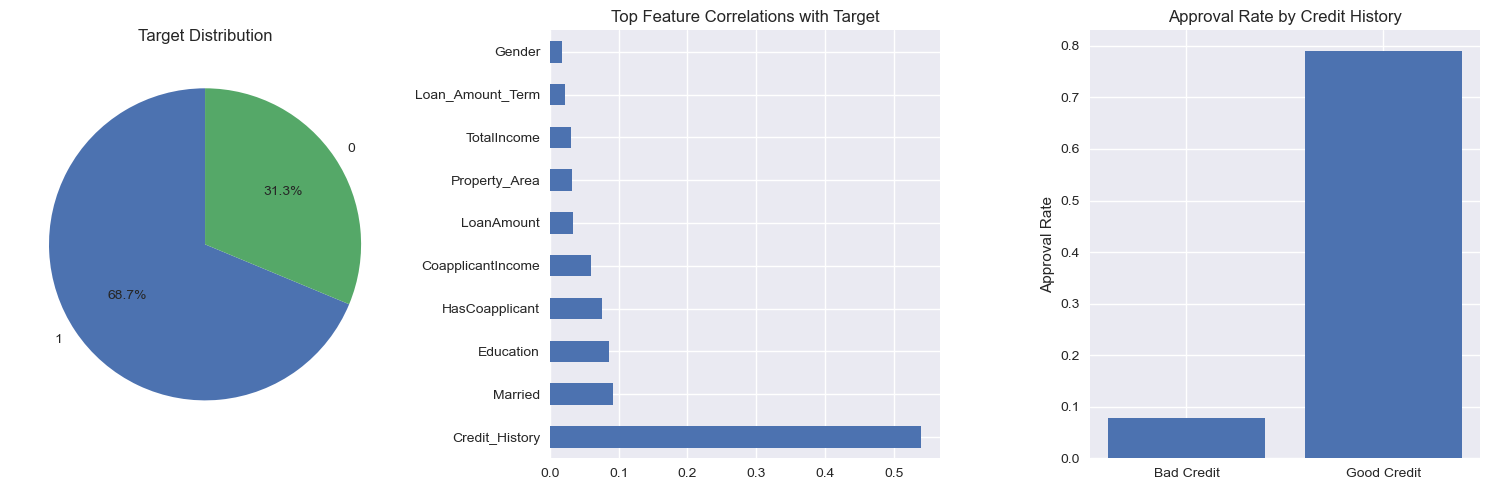


📊 Step 3: Train-Validation Split...
✅ X_train: (491, 13), y_train: (491,)
✅ X_val: (123, 13), y_val: (123,)

📊 Step 4: Advanced Feature Engineering...
✅ X_train_advanced: (491, 21)
✅ X_val_advanced: (123, 21)

📊 Step 5: Preprocessing Test Data...
✅ Test data shape: (367, 21)

🤖 Step 6: Model Training...
🔄 Applying SMOTE to handle class imbalance...
Before SMOTE: [154 337]
After SMOTE: [337 337]

Training LogisticRegression

LogisticRegression Performance:
Accuracy: 0.8537
AUC Score: 0.8563

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.78      0.74      0.76        38
    Approved       0.89      0.91      0.90        85

    accuracy                           0.85       123
   macro avg       0.83      0.82      0.83       123
weighted avg       0.85      0.85      0.85       123



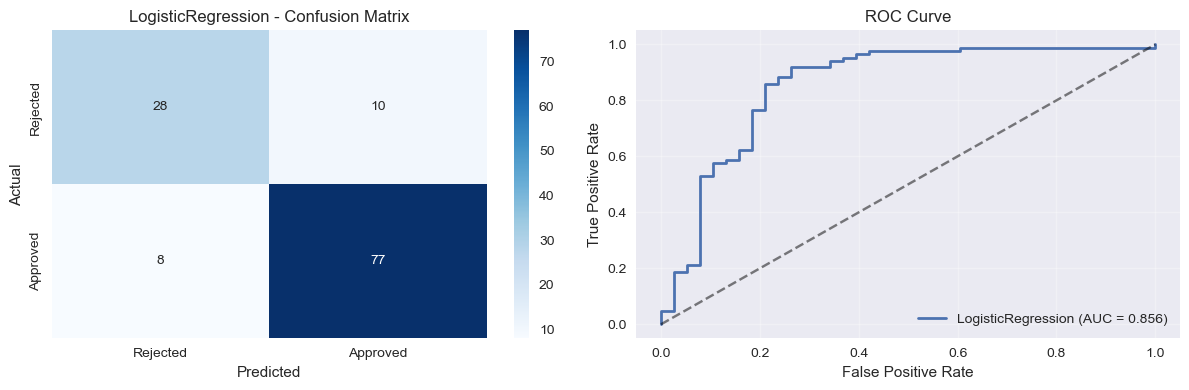


Training RandomForest

RandomForest Performance:
Accuracy: 0.7886
AUC Score: 0.8546

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.63      0.76      0.69        38
    Approved       0.88      0.80      0.84        85

    accuracy                           0.79       123
   macro avg       0.76      0.78      0.76       123
weighted avg       0.81      0.79      0.79       123



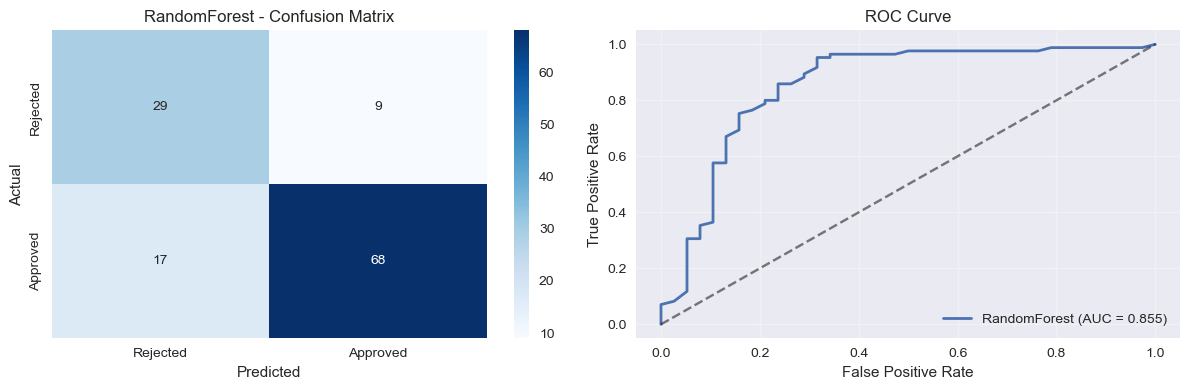


Training XGBoost

XGBoost Performance:
Accuracy: 0.7398
AUC Score: 0.8266

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.56      0.74      0.64        38
    Approved       0.86      0.74      0.80        85

    accuracy                           0.74       123
   macro avg       0.71      0.74      0.72       123
weighted avg       0.77      0.74      0.75       123



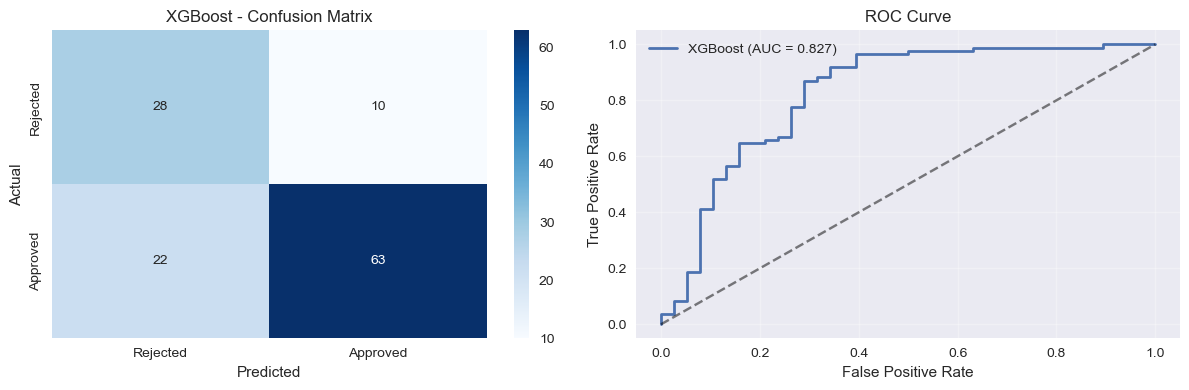


Training GradientBoosting

GradientBoosting Performance:
Accuracy: 0.7805
AUC Score: 0.8466

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.63      0.71      0.67        38
    Approved       0.86      0.81      0.84        85

    accuracy                           0.78       123
   macro avg       0.75      0.76      0.75       123
weighted avg       0.79      0.78      0.78       123



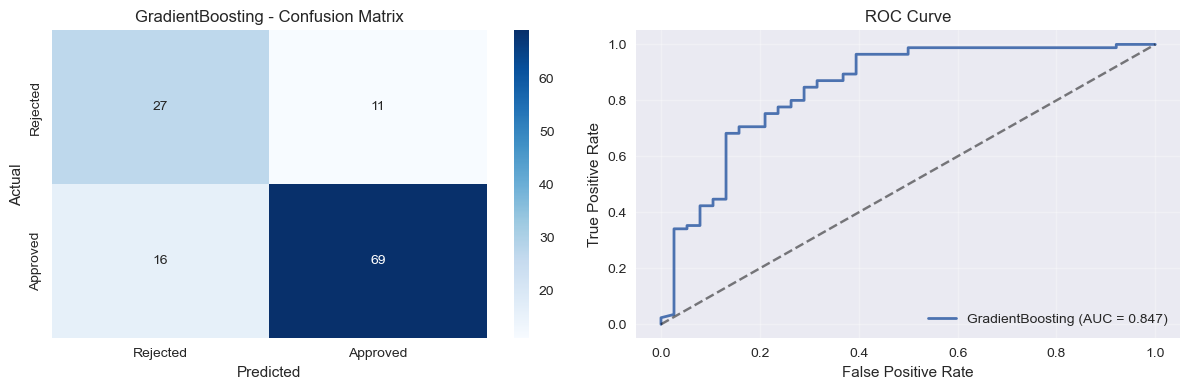


🔗 Step 7: Ensemble Creation...

Top models for ensemble:
LogisticRegression: AUC = 0.8563
RandomForest: AUC = 0.8546
GradientBoosting: AUC = 0.8466

Voting Ensemble Performance:
Accuracy: 0.8211
AUC Score: 0.8666

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.70      0.74      0.72        38
    Approved       0.88      0.86      0.87        85

    accuracy                           0.82       123
   macro avg       0.79      0.80      0.79       123
weighted avg       0.82      0.82      0.82       123



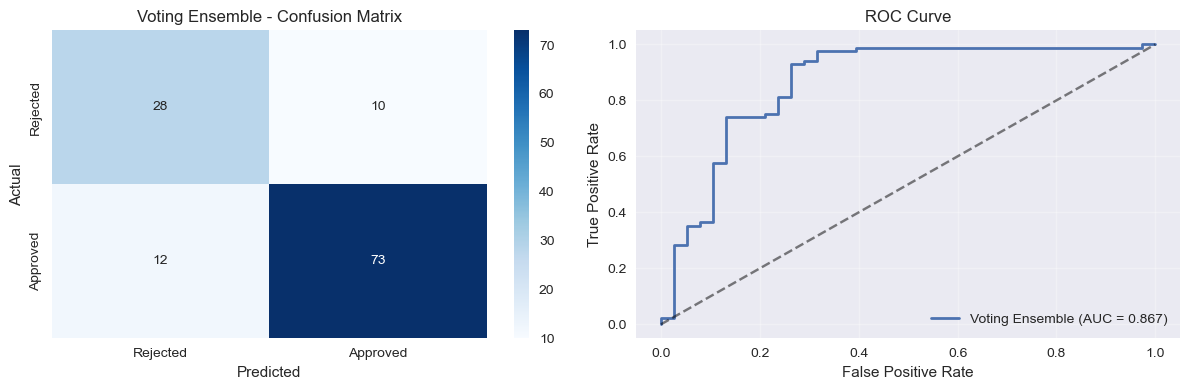


🏆 FINAL MODEL COMPARISON
                Model  Accuracy  AUC_Score
4            Ensemble  0.821138   0.866563
0  LogisticRegression  0.853659   0.856347
1        RandomForest  0.788618   0.854644
3    GradientBoosting  0.780488   0.846594
2             XGBoost  0.739837   0.826625

🎯 Best Model: Ensemble

📤 Step 8: Creating Submission...

🔧 Preparing submission with 21 features...
✅ Final test shape: (367, 21)
✅ Column match: True

✅ Submission file 'loan_prediction_submission_Ensemble.csv' created successfully!
📊 Predictions distribution:
Loan_Status
Y    268
N     99
Name: count, dtype: int64
📈 Approval rate: 73.0%

📋 Sample predictions:
    Loan_ID Loan_Status  Probability_Approval
0  LP001015           Y              0.626117
1  LP001022           Y              0.870297
2  LP001031           Y              0.803499
3  LP001035           Y              0.878430
4  LP001051           Y              0.651058
5  LP001054           Y              0.750817
6  LP001055           N     

In [70]:
if __name__ == "__main__":
    final_submission, results, best_model = main()